In [26]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import statsmodels.api as sm
from tqdm import tqdm
import time
from matplotlib.patches import Patch

In [9]:
# config 
voxel_size_um = 25 # um per voxel 25um
min_mean_bundle_density = 1e-4  

# structures
isocortex_id = 315
bundle_ids = [884] # replace with any fiber tract ids 

# hemisphere: right, left, or None 
hemisphere = "right"

# cache and structure tree from allensdk
mcc = MouseConnectivityCache()
st = mcc.get_structure_tree()

In [10]:
# experiments 
print("loading isocortex non-cre injection experiments")
exps = mcc.get_experiments(cre=False, injection_structure_ids=[isocortex_id])
experiment_ids = [e["id"] for e in exps]
print(f"using {len(experiment_ids)} isocortex experiments")

loading isocortex non-cre injection experiments...
using 129 isocortex experiments


In [11]:
# build bundle mask 
mask_union = None
for sid in bundle_ids:
    m, _ = mcc.get_structure_mask(sid)
    mask_union = m.astype(bool) if mask_union is None else (mask_union | m.astype(bool))

if mask_union is None:
    raise RuntimeError("no structure masks were built (check bundle_ids).")

# restrict to one hemisphere 
if hemisphere in ("right", "left"):
    mid = mask_union.shape[2] // 2
    if hemisphere == "right":
        mask_union[:, :, :mid] = False
    else:
        mask_union[:, :, mid:] = False

# precompute voxel indices
mx, my, mz = np.where(mask_union)
mask_index_tuple = (mx, my, mz)
print(f"mask ready: {mx.size:,} voxels ({hemisphere or 'both'} hemisphere)")

mask ready: 5,177 voxels (right hemisphere)


In [12]:
# HELPERS
# density volumes are 3d arrays where each allensdk voxel stores the fraction of the
# voxel filled by signal. Density values are between 0 and 1
# as written in the allen dev docs: 
# projection density= sum of detected projection pixels / sum of all pixels in voxel
# injection_density= density of detected projection pixels within the 
# manually annotated injection site

# this gets the projection crossing coordinates within mask using density values
def weighted_centroid_from_density(density_vol, idx_tuple, voxel_size_um):
    w = density_vol[idx_tuple]  # get projection density values inside your mask
    pos = w > 0  # keep only voxels with nonzero density
    if not np.any(pos):  # if no signal at all, return None
        return None

    x = idx_tuple[0][pos] # x voxel indices of nonzero voxels
    y = idx_tuple[1][pos] # y voxel indices
    z = idx_tuple[2][pos] # z voxel indices
    w = w[pos].astype(np.float32) # weights = projection density values

# weighted average voxel index + converted to um
    vx = float(np.average(x, weights=w)) * voxel_size_um
    vy = float(np.average(y, weights=w)) * voxel_size_um
    vz = float(np.average(z, weights=w)) * voxel_size_um
    return vx, vy, vz
                  
#finds the center of mass of the projection signal within wm mask
# weights projection densities so that brighter voxels influence the centroid more

# this gets the injection site centroid based on all nonzero voxels in injection volume 
def weighted_centroid_from_binary(density_vol, voxel_size_um):
    pos = density_vol > 0 # find voxels with injection signal
    if not np.any(pos): # if no injection voxels, return None
        return None
    x, y, z = np.where(pos)    # voxel coordinates of injection
    w = density_vol[pos].astype(np.float32) # injection densities as weights

    # weighted centroid
    vx = float(np.average(x, weights=w)) * voxel_size_um
    vy = float(np.average(y, weights=w)) * voxel_size_um
    vz = float(np.average(z, weights=w)) * voxel_size_um
    return vx, vy, vz
# finds the weighted center of the injection site
# weighs injection densitites so that denser parts of the injection count more
# outputs injection centroid

In [13]:
# main loop
inj_x, inj_y, inj_z = {}, {}, {}
proj_x, proj_y, proj_z = {}, {}, {}

t0 = time.time()
for eid in tqdm(experiment_ids, desc="processing experiments"):
    try:
        proj_vol, _ = mcc.get_projection_density(eid)   # 3d projection density volume
        inj_vol, _  = mcc.get_injection_density(eid)    # 3d injection density volume

        # projection densities inside WM mask (after hemisphere filtering)
        wm_densities = proj_vol[mask_index_tuple].astype(np.float32)

        # drop NaNs 
        wm_densities = wm_densities[~np.isnan(wm_densities)]
        # skip if no valid voxels in the bundle
        if wm_densities.size == 0:
            continue
        # mean projection density through the WM structure
        bundle_mean = float(np.mean(wm_densities))
        # filter: require mean density >= threshold
        if bundle_mean < min_mean_bundle_density:
            continue
        # centroids only for experiments that passed the filter
        proj_centroid = weighted_centroid_from_density(
            proj_vol, mask_index_tuple, voxel_size_um
        )
        if proj_centroid is None:
            continue
        px, py, pz = proj_centroid
        proj_x[eid], proj_y[eid], proj_z[eid] = px, py, pz

        inj_centroid = weighted_centroid_from_binary(inj_vol, voxel_size_um)
        if inj_centroid is None:
            continue
        ix, iy, iz = inj_centroid
        inj_x[eid], inj_y[eid], inj_z[eid] = ix, iy, iz

    except Exception as e:
        print(f"{eid}: {e}")

elapsed = time.time() - t0
print(f"\n total processing time: {elapsed:.2f} s")

# how many experiments were kept?
kept_ids = sorted(proj_x.keys())
print(f"kept {len(kept_ids)} / {len(experiment_ids)} experiments "
      f"(mean WM density ≥ {min_mean_bundle_density})")
print("first few kept IDs + means:")
for eid in kept_ids[:10]:
    # recompute just for display
    proj_vol, _ = mcc.get_projection_density(eid)
    wm = proj_vol[mask_index_tuple].astype(np.float32)
    wm = wm[~np.isnan(wm)]
    print(eid, np.mean(wm))


processing experiments: 100%|█████████████████| 129/129 [09:21<00:00,  4.35s/it]



⏱️ total processing time: 561.02 s
kept 93 / 129 experiments (mean WM density ≥ 0.0001)
first few kept IDs + means:
100140756 0.0008923684
100141219 0.00010548638
100141273 0.00012482444
100141454 0.0001594399
100141473 0.0003344146
100141495 0.00012477631
100141599 0.0007255982
100141780 0.0016147945
100141796 0.07234196
100148503 0.000117306925


In [14]:
# dataframe + correlation 
common_ids = sorted(set(inj_x) & set(proj_x))

df = pd.DataFrame({
    "injection_x":  [inj_x[e]  for e in common_ids],
    "injection_y":  [inj_y[e]  for e in common_ids],
    "injection_z":  [inj_z[e]  for e in common_ids],
    "projection_x": [proj_x[e] for e in common_ids],
    "projection_y": [proj_y[e] for e in common_ids],
    "projection_z": [proj_z[e] for e in common_ids],
}, index=common_ids)

print(f"final n = {len(df)} rows")
print("\ncorrelation matrix (injection → projection):")
print(df.corr(numeric_only=True))

final n = 93 rows

correlation matrix (injection → projection):
              injection_x  injection_y  injection_z  projection_x  \
injection_x      1.000000    -0.450832     0.576135      0.617669   
injection_y     -0.450832     1.000000     0.294347     -0.277134   
injection_z      0.576135     0.294347     1.000000      0.099681   
projection_x     0.617669    -0.277134     0.099681      1.000000   
projection_y    -0.645295     0.374536    -0.128613     -0.912427   
projection_z     0.620164    -0.316851     0.097881      0.971533   

              projection_y  projection_z  
injection_x      -0.645295      0.620164  
injection_y       0.374536     -0.316851  
injection_z      -0.128613      0.097881  
projection_x     -0.912427      0.971533  
projection_y      1.000000     -0.975037  
projection_z     -0.975037      1.000000  


In [15]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(df, predictors):
    X = df[predictors].dropna().astype(float).values
    X_ = np.column_stack([np.ones(X.shape[0]), X])

    vif_vals = [variance_inflation_factor(X_, i) for i in range(1, X_.shape[1])]

    vif_table = pd.DataFrame({
        "predictor": predictors,
        "VIF": vif_vals
    })

    def interpret(v):
        if v < 2:
            return "low collinearity"
        elif v < 5:
            return "moderate collinearity"
        elif v < 10:
            return "high collinearity"
        else:
            return "severe collinearity"

    vif_table["interpretation"] = vif_table["VIF"].apply(interpret)
    return vif_table

predictors = ['injection_x','injection_y','injection_z']
vif_table = compute_vif(df, predictors)
print(vif_table)

     predictor       VIF         interpretation
0  injection_x  4.054473  moderate collinearity
1  injection_y  2.965607  moderate collinearity
2  injection_z  3.536837  moderate collinearity


In [ ]:
# Lasso regression

In [42]:
# attach region labels to df using experiment injection structure acronyms 
# build: exp_id to injection structure acronym
exp_struct_acro = {}
for e in exps:
    try:
        s = st.get_structures_by_id([e['structure_id']])[0]
        exp_struct_acro[e['id']] = s['acronym']
    except Exception:
        pass

# keep only rows present in df.index
df_regions = df.copy()
df_regions['region'] = [get_region_group(exp_struct_acro.get(eid, None)) for eid in df_regions.index]
df_regions = df_regions[df_regions['region'].notna()]
print(f"region-labeled n = {len(df_regions)} (dropped unlabeled)")

region-labeled n = 92 (dropped unlabeled)


In [43]:
# modeling helpers
predictor_cols = ['injection_x', 'injection_y', 'injection_z']
axis_map = {'x': 'projection_x', 'y': 'projection_y', 'z': 'projection_z'}
axis_label = {'x': 'A-P', 'y': 'D-V', 'z': 'M-L'}

def fit_models(df_in: pd.DataFrame):
    x = sm.add_constant(df_in[predictor_cols])
    models = {}
    for ax, ycol in axis_map.items():
        y = df_in[ycol]
        models[ax] = sm.OLS(y, x).fit()
    return models

models = fit_models(df_regions)

In [44]:
print("Experiments with NaN projection centroids:", 
      sum(np.isnan(list(proj_x.values()))))
print("Experiments used in regression dataframe:", len(df))

Experiments with NaN projection centroids: 0
Experiments used in regression dataframe: 93


In [45]:
# Color palette 
region_colors = {
    'Prefrontal':    {'acronyms': {'ACAd','ACAv','FRP','ILA','ORBl','ORBvl','PL'},
                      'color': [0.97, 0.83, 0.34]},
    'Insula':        {'acronyms': {'AId','GU','VISC'},
                      'color': [1.00, 0.62, 0.23]},
    'Motor':         {'acronyms': {'MOp','MOs'},
                      'color': [0.40, 0.76, 0.40]},
    'Somatosensory': {'acronyms': {'SSp-bfd','SSp-ll','SSp-m','SSp-n','SSp-tr','SSp-ul','SSp-un','SSs'},
                      'color': [0.85, 0.19, 0.20]},
    'Temporal':      {'acronyms': {'ECT','AUDd','AUDp','AUDpo','AUDv'},
                      'color': [1.00, 0.45, 0.71]},
    'Retrosplenial': {'acronyms': {'RSPagl','RSPd','RSPv'},
                      'color': [0.78, 0.00, 1.00]},
    'Visual':        {'acronyms': {'VISp','VISal','VISam','VISl','VISpm','VISpor','VISpl','VISli'},
                      'color': [0.00, 0.55, 1.00]}
}

legend_order = ["Prefrontal", "Insula", "Motor",
                "Somatosensory", "Temporal", "Retrosplenial", "Visual"]

# Convert RGB to hex
def rgb_to_hex(rgb):
    r, g, b = (int(255*c) for c in rgb)
    return f"#{r:02x}{g:02x}{b:02x}"

group_color_hex = {k: rgb_to_hex(v['color']) for k, v in region_colors.items()}

#  Helper to get region group by acronym 
def get_region_group(acronym: str):
    for group, props in region_colors.items():
        if acronym in props['acronyms']:
            return group
    return None

In [46]:
# lasso imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from matplotlib.patches import Patch

In [47]:
# axis labels and column mappings
axis_label = {'x': 'A-P', 'y': 'D-V', 'z': 'M-L'}

predictors = [
    'injection_x',
    'injection_y',
    'injection_z'
]

axis_to_ycol = {
    'x': 'projection_x',
    'y': 'projection_y',
    'z': 'projection_z'
}

In [48]:
def fit_lasso_models(df, axes=('x', 'y', 'z'), cv=5, alphas=None, random_state=0):
    """
    Fit one LassoCV model per projection axis on standardized predictors.

    Returns:
        dict: axis {
            'scaler': StandardScaler,
            'model': LassoCV,
            'index': DataFrame index used for fitting
        }
    """
    models = {}

    for ax in axes:
        cols = predictors + [axis_to_ycol[ax]]
        sub = df.dropna(subset=cols).copy()

        X = sub[predictors].to_numpy(float)
        y = sub[axis_to_ycol[ax]].to_numpy(float)

        scaler = StandardScaler()
        Xz = scaler.fit_transform(X)

        lcv = LassoCV(
            cv=cv,
            alphas=alphas,
            random_state=random_state,
            max_iter=10000
        )
        lcv.fit(Xz, y)

        models[ax] = {
            'scaler': scaler,
            'model': lcv,
            'index': sub.index
        }

    return models

In [49]:
def plot_axis_summary_lasso(
    models,
    df_regions,
    group_color_hex,
    legend_order,
    axis_key='x'
):
    """
    Two-panel summary for a single axis using LassoCV.

    Left:
        Predicted vs actual projection coordinate, colored by region.
    Right:
        Lasso coefficients (betas) on standardized predictors.

    Title reports R squared and chosen alpha.
    """
    assert axis_key in ('x', 'y', 'z')

    pack   = models[axis_key]
    scaler = pack['scaler']
    lcv    = pack['model']

    # align rows used by the model
    idx = pack['index']
    X = df_regions.loc[idx, predictors].to_numpy(float)
    y = df_regions.loc[idx, axis_to_ycol[axis_key]].to_numpy(float)
    Xz = scaler.transform(X)
    y_pred = lcv.predict(Xz)

    fig, (ax_scatter, ax_bar) = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(12, 5),
        gridspec_kw={'width_ratios': [1.25, 1]}
    )

    # predicted vs actual 
    for region in legend_order:
        if region not in group_color_hex:
            continue

        mask = (df_regions.loc[idx, 'region'] == region).to_numpy()
        if not np.any(mask):
            continue

        ax_scatter.scatter(
            y_pred[mask],
            y[mask],
            s=70,
            edgecolor='black',
            alpha=0.85,
            color=group_color_hex[region],
            label=region
        )

    lo = float(min(y.min(), y_pred.min()))
    hi = float(max(y.max(), y_pred.max()))
    ax_scatter.plot([lo, hi], [lo, hi], 'r--', lw=2)

    pretty = axis_label[axis_key]
    r2 = r2_score(y, y_pred)
    ax_scatter.set_xlabel(f"Predicted {pretty} Projection (µm)")
    ax_scatter.set_ylabel(f"Actual {pretty} Projection (µm)")
    ax_scatter.set_title(f"{pretty} Prediction (LassoCV: R²={r2:.3f}, α={lcv.alpha_:.3g})")
    ax_scatter.grid(True, linestyle='--', alpha=0.6)

    #  RIGHT: beta bars (standardized-X coefficients) 
    coef = lcv.coef_  # corresponds to predictors after standardization
    label_map = {
        'injection_x': 'A-P Injection Coordinate',
        'injection_y': 'D-V Injection Coordinate',
        'injection_z': 'M-L Injection Coordinate'
    }
    labels = [label_map[p] for p in predictors]
    bars = ax_bar.bar(labels, coef, color='skyblue', edgecolor='black')

    # annotate zeros and values
    rng = (max(coef.max(), 0) - min(coef.min(), 0)) or 1.0
    for b, v in zip(bars, coef):
        ytxt = (b.get_height() + 0.05*rng) if v >= 0 else (b.get_height() - 0.05*rng)
        va   = 'bottom' if v >= 0 else 'top'
        ax_bar.text(b.get_x()+b.get_width()/2, ytxt, f"{v:.3f}", ha='center', va=va, fontsize=10)

    ax_bar.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax_bar.set_ylabel("Lasso coefficient (β) on standardized predictors")
    ax_bar.set_title(f"Influence of Injection Coordinates\non {pretty} Projection")
    ax_bar.grid(True, axis='y', linestyle='--', alpha=0.6)
    ax_bar.tick_params(axis='x', labelrotation=20)

    plt.tight_layout()
    plt.show()

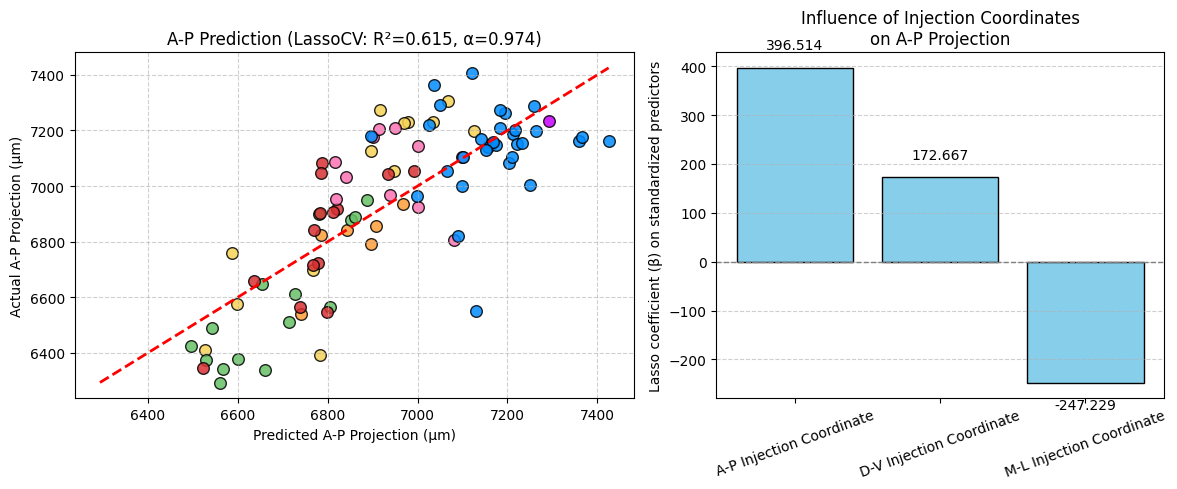

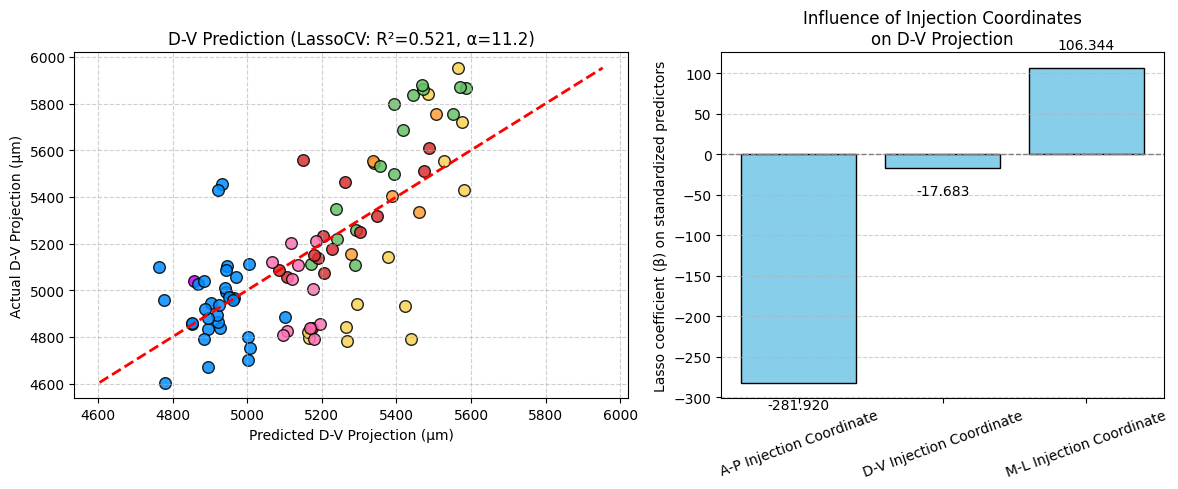

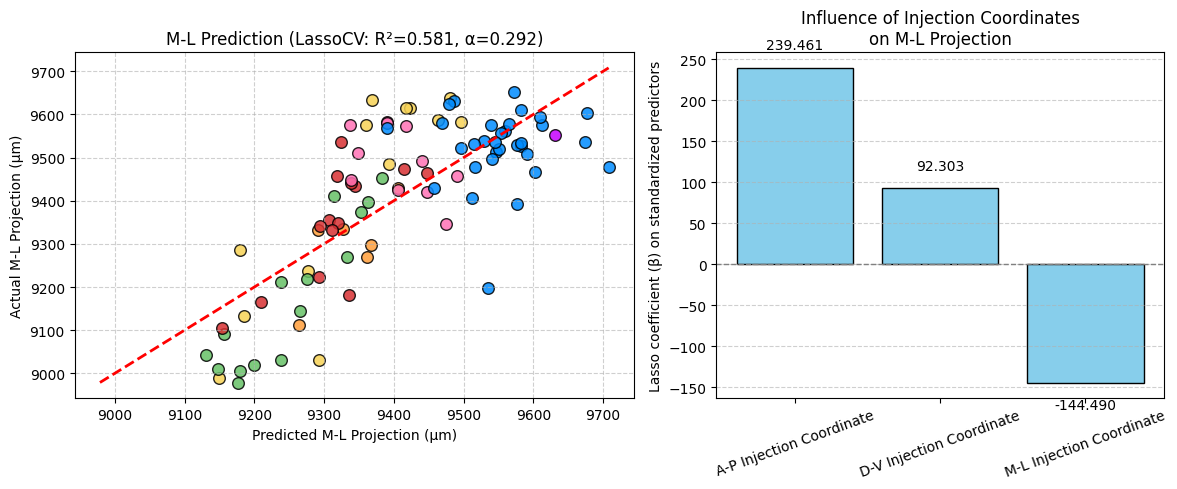

In [50]:
# fit lasso models 
lasso_models = fit_lasso_models(df_regions, cv=5)

# plot 
plot_axis_summary_lasso(lasso_models, df_regions, group_color_hex, legend_order, axis_key='x')  # A-P
plot_axis_summary_lasso(lasso_models, df_regions, group_color_hex, legend_order, axis_key='y')  # D-V
plot_axis_summary_lasso(lasso_models, df_regions, group_color_hex, legend_order, axis_key='z')  # M-L

In [38]:
# partial regression plots

In [52]:
# labels and columns
axis_label    = {'x': 'A-P', 'y': 'D-V', 'z': 'M-L'}
predictors    = ['injection_x', 'injection_y', 'injection_z']
axis_to_ycol  = {'x': 'projection_x', 'y': 'projection_y', 'z': 'projection_z'}

def _residualize(y, X):
    """Return residuals of OLS: y ~ X (with constant)."""
    Xc = sm.add_constant(X, has_constant='add')
    model = sm.OLS(y, Xc, missing='drop').fit()
    return model.resid, model

def partial_regression_plots(
    df_regions,
    axis_key='x',
    group_color_hex=None,
    legend_order=None,
    point_size=70,
    alpha=0.85,
    show=True
):
    """
    Added-variable plots for a chosen projection axis.
    Rows used: non-NA on projection axis + all three predictors.
    Returns (fig, axes, full_model) where full_model is OLS on all 3 predictors.
    """
    assert axis_key in ('x','y','z')
    ycol = axis_to_ycol[axis_key]

    # rows with complete data
    needed = predictors + [ycol]
    d = df_regions.dropna(subset=needed).copy()

    # Fit the full OLS once (y ~ X,Y,Z) for reference
    X_full = sm.add_constant(d[predictors], has_constant='add')
    full_model = sm.OLS(d[ycol], X_full).fit()

    # figure: one subplot per predictor
    fig, axes = plt.subplots(1, 3, figsize=(16, 4.8), sharey=False)
    fig.suptitle(f"Partial regression (added-variable) plots for {axis_label[axis_key]} projection", y=1.02)

    for ax, pred in zip(axes, predictors):
        others = [p for p in predictors if p != pred]

        # residualize outcome on "others", and predictor on "others"
        y_res, _  = _residualize(d[ycol].to_numpy(float), d[others].to_numpy(float))
        x_res, _  = _residualize(d[pred].to_numpy(float), d[others].to_numpy(float))

        # quick simple regression on residuals -> partial slope & p-value
        lr = linregress(x_res, y_res)
        slope, intercept, r_val, p_val = lr.slope, lr.intercept, lr.rvalue, lr.pvalue

        # scatter (by region if provided)
        if group_color_hex and 'region' in d.columns and legend_order:
            for region in legend_order:
                if region not in group_color_hex:
                    continue
                m = (d['region'] == region).to_numpy()
                if not np.any(m):
                    continue
                ax.scatter(
                    x_res[m], y_res[m],
                    s=point_size, alpha=alpha,
                    color=group_color_hex[region],
                    edgecolor='black', linewidths=0.5
                )
        else:
            ax.scatter(x_res, y_res, s=point_size, alpha=alpha,
                       color='#4c78a8', edgecolor='black', linewidths=0.5)

        # regression line on residuals
        xx = np.linspace(x_res.min(), x_res.max(), 100)
        ax.plot(xx, intercept + slope*xx, 'r--', lw=2)

        # labels and title with stats
        nice_pred = {
            'injection_x': 'A-P injection',
            'injection_y': 'D-V injection',
            'injection_z': 'M-L injection'
        }[pred]
        ax.set_xlabel(f"{nice_pred} residual (µm)")
        ax.set_ylabel(f"{axis_label[axis_key]} projection residual (µm)")
        beta_full = full_model.params[pred]  # equals slope on residuals
        ax.set_title(f"{nice_pred} | others\nβ={beta_full:.3f},  R²={r_val**2:.2f},  p={p_val:.2e}")
        ax.grid(True, linestyle='--', alpha=0.5)

    # shared legend (if region colors provided)
    if group_color_hex and legend_order:
        handles = [Patch(facecolor=group_color_hex[r], edgecolor='black', label=r)
                   for r in legend_order if r in group_color_hex]
        fig.legend(handles=handles, title='region', bbox_to_anchor=(1.01, 0.5), loc='center left')

    plt.tight_layout(rect=[0, 0, 0.95, 1])
    if show:
        plt.show()
    return fig, axes, full_model

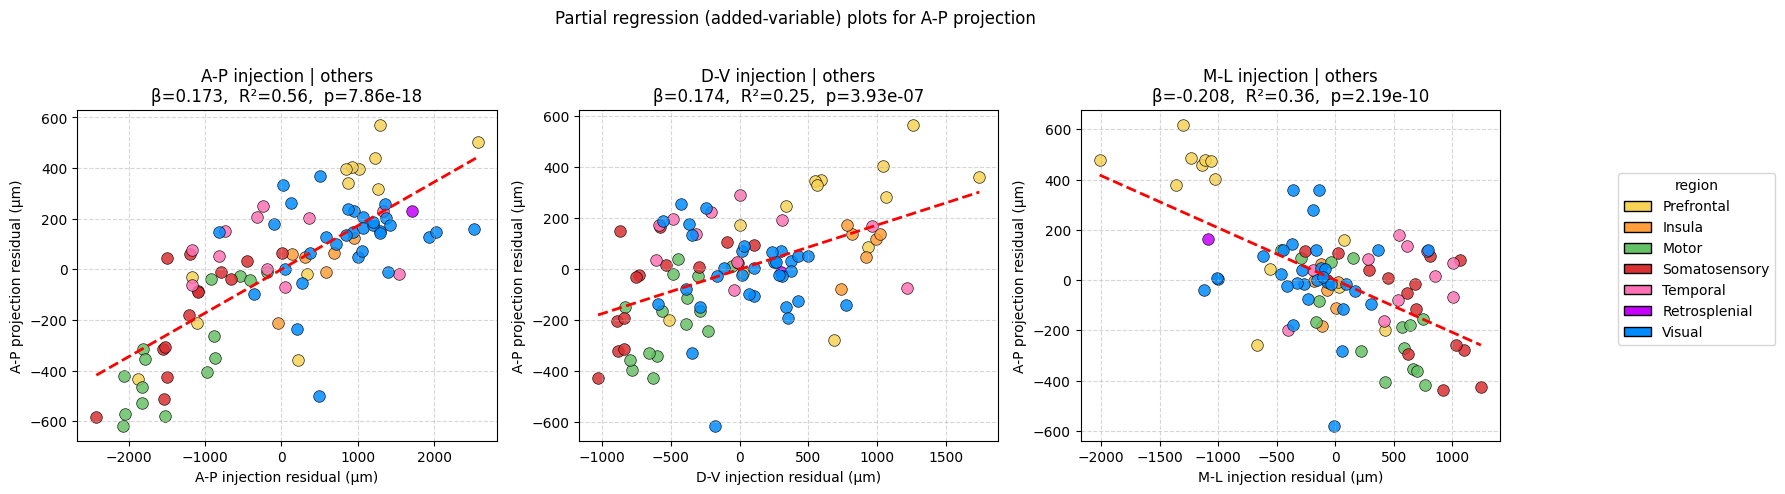

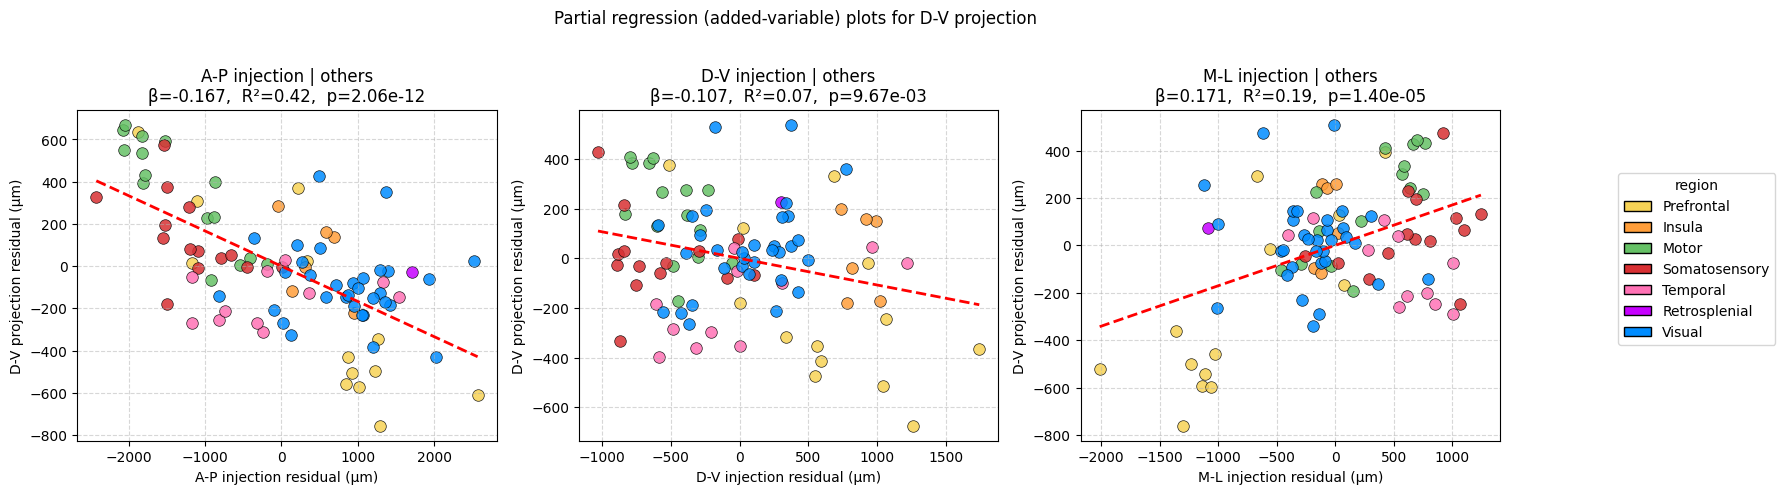

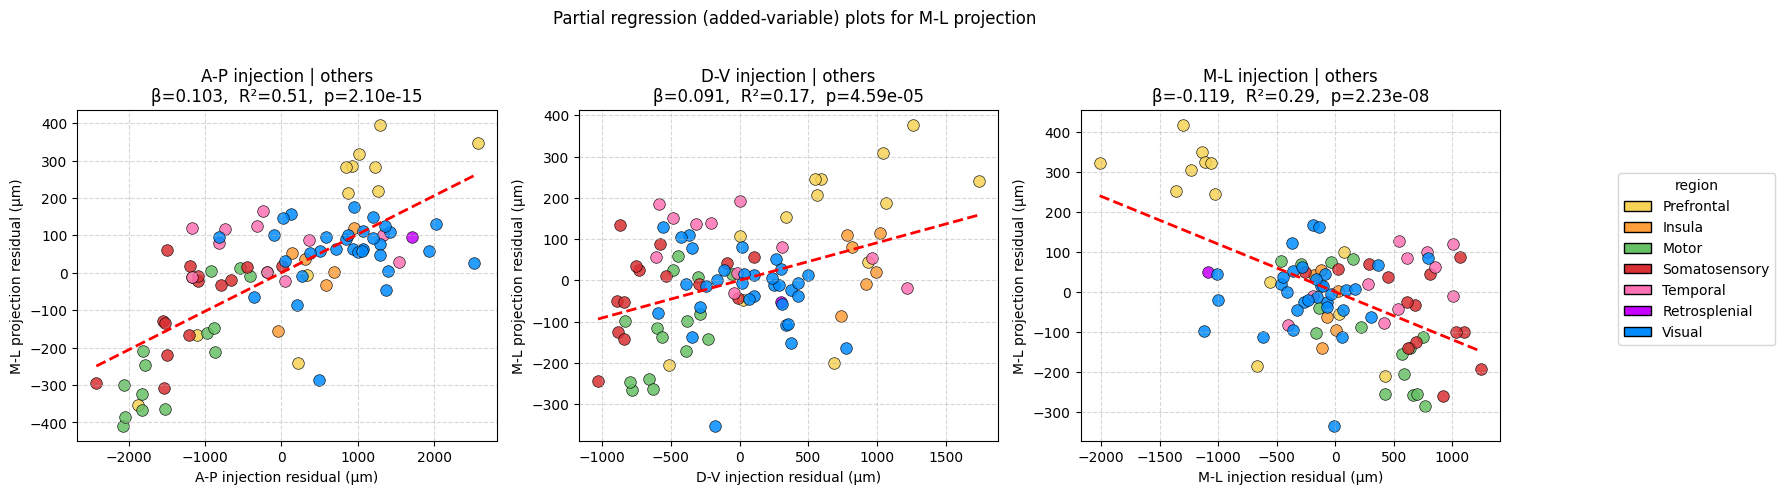

(<Figure size 1600x480 with 3 Axes>,
 array([<Axes: title={'center': 'A-P injection | others\nβ=0.103,  R²=0.51,  p=2.10e-15'}, xlabel='A-P injection residual (µm)', ylabel='M-L projection residual (µm)'>,
        <Axes: title={'center': 'D-V injection | others\nβ=0.091,  R²=0.17,  p=4.59e-05'}, xlabel='D-V injection residual (µm)', ylabel='M-L projection residual (µm)'>,
        <Axes: title={'center': 'M-L injection | others\nβ=-0.119,  R²=0.29,  p=2.23e-08'}, xlabel='M-L injection residual (µm)', ylabel='M-L projection residual (µm)'>],
       dtype=object),
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1702ee100>)

In [53]:
# plot
fig, axes, full_ap = partial_regression_plots(
    df_regions,
    axis_key='x',
    group_color_hex=group_color_hex,
    legend_order=legend_order
)
partial_regression_plots(df_regions, axis_key='y', group_color_hex=group_color_hex, legend_order=legend_order)
partial_regression_plots(df_regions, axis_key='z', group_color_hex=group_color_hex, legend_order=legend_order)